## Import data

In [68]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

df = pd.read_csv('cars_data_2023.csv')

print(df.shape)
print(df.dtypes)
df.head()

(3377, 44)
Model Year                          int64
Represented Test Veh Make          object
Represented Test Veh Model         object
Test Vehicle ID                    object
Test Veh Configuration #            int64
Test Veh Displacement (L)         float64
Vehicle Type                       object
Rated Horsepower                    int64
# of Cylinders and Rotors         float64
Tested Transmission Type Code      object
Tested Transmission Type           object
# of Gears                          int64
Drive System Description           object
Transmission Overdrive Desc        object
Equivalent Test Weight (lbs.)       int64
Axle Ratio                        float64
N/V Ratio                         float64
Shift Indicator Light Use Desc     object
Test Number                        object
Test Procedure Description         object
Test Fuel Type Cd                   int64
Test Fuel Type Description         object
Test Category                      object
THC (g/mi)             

,Model Year,Represented Test Veh Make,Represented Test Veh Model,Test Vehicle ID,Test Veh Configuration #,Test Veh Displacement (L),Vehicle Type,Rated Horsepower,# of Cylinders and Rotors,Tested Transmission Type Code,...,DT-Energy Economy Rating,Target Coef A (lbf),Target Coef B (lbf/mph),Target Coef C (lbf/mph**2),Set Coef A (lbf),Set Coef B (lbf/mph),Set Coef C (lbf/mph**2),Aftertreatment Device Cd,Aftertreatment Device Desc,Police - Emergency Vehicle?
0,2023,Aston Martin,DB11 V8,562TT5348,0,4.0,Car,503,8.0,SA,...,-7.71,40.94,0.0169,0.0271,11.26,0.0919,0.0251,TWC,Three-way catalyst,N
1,2023,Aston Martin,DB11 V8,562TT5348,0,4.0,Car,503,8.0,SA,...,-0.96,40.94,0.0169,0.0271,11.26,0.0919,0.0251,TWC,Three-way catalyst,N
2,2023,Aston Martin,DBS,7002PT7056,0,5.2,Car,715,12.0,SA,...,-0.58,40.94,0.0169,0.0271,6.81,0.0807,0.0245,TWC,Three-way catalyst,N
3,2023,Aston Martin,DBS,7002PT7056,0,5.2,Car,715,12.0,SA,...,-0.08,40.94,0.0169,0.0271,6.81,0.0807,0.0245,TWC,Three-way catalyst,N
4,2023,Aston Martin,DBX,8001PT8342,1,4.0,Both,550,8.0,A,...,-2.11,60.68,-0.3286,0.0373,-4.88,-0.5318,0.0367,TWC,Three-way catalyst,N


## EDA

There are many outliers in RND_ADJ_FE and Rated Horsepower. Missing value exists in RND_ADJ_FE and CO2.

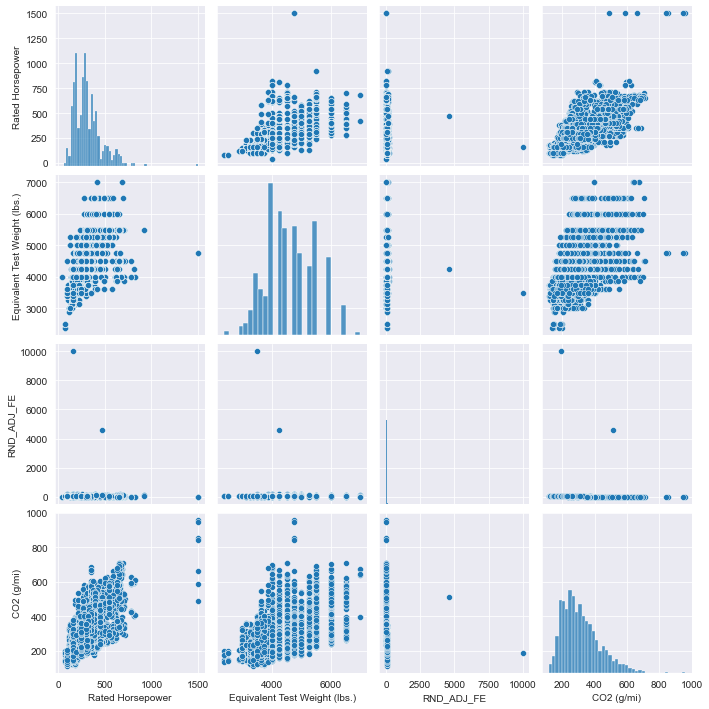

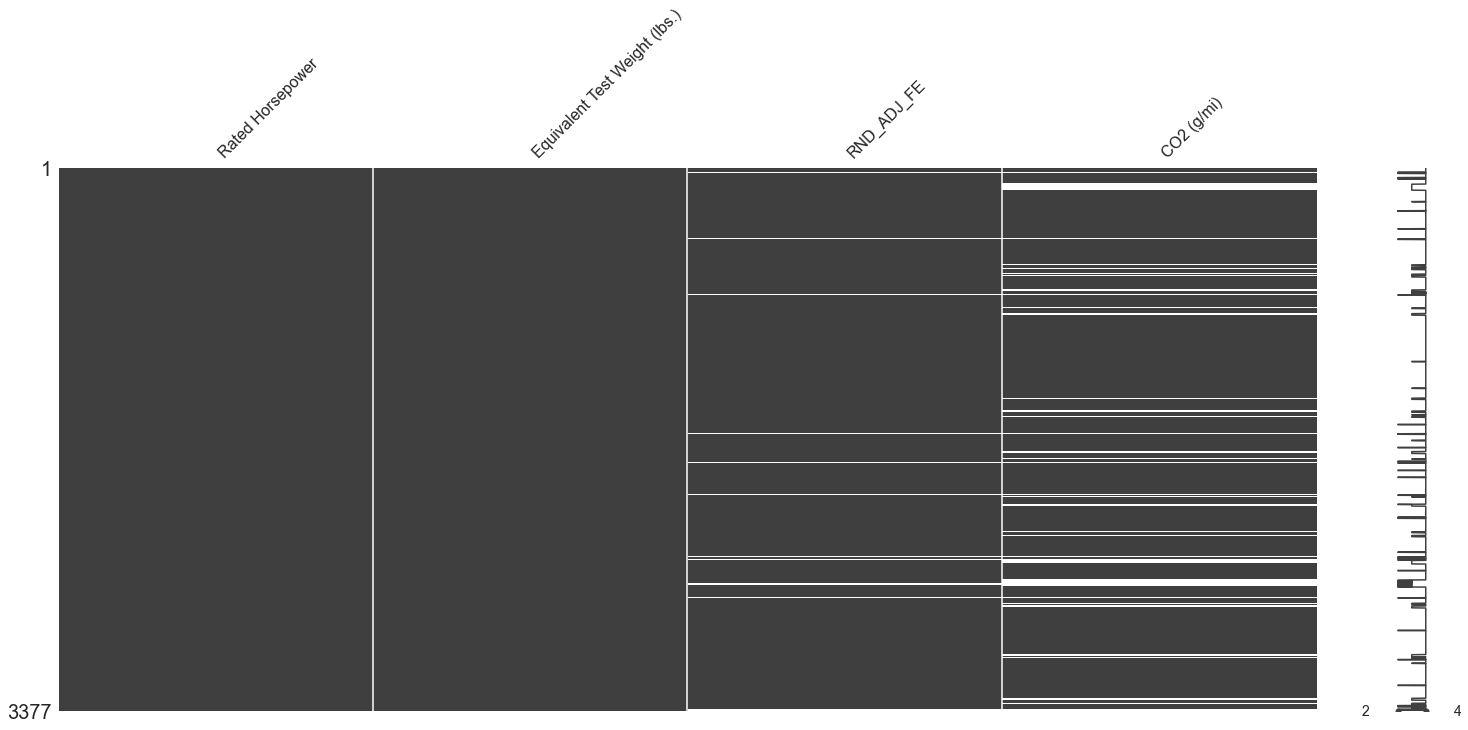

In [69]:
import seaborn as sns
import missingno as msno

df_new = df[['Rated Horsepower', 'Equivalent Test Weight (lbs.)', 'RND_ADJ_FE', 'CO2 (g/mi)']]

sns.pairplot(data=df_new);
msno.matrix(df_new);


Drop na.

In [70]:
df_dna = df_new.dropna()

Drop outliers.

In [71]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

# Identify outliers using LocalOutlierFactor.
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred_lof = lof.fit_predict(df_dna)

# Identify outliers using IsolationForest.
iforest = IsolationForest(n_estimators=100,  contamination=0.05)
y_pred_if = iforest.fit_predict(df_dna)

# Identify outliers using EllipticEnvelope.
rob_cov = EllipticEnvelope(contamination=0.05)
rob_cov.fit(df_dna)
y_pred_rob = rob_cov.predict(df_dna)

df_dna["y_pred_lof"] = y_pred_lof
df_dna["y_pred_if"] = y_pred_if
df_dna["y_pred_rob"] = y_pred_rob

# -----------------------------------------------------------------------------
# Converting them to a binary -1, 0.
# Where -1 denotes outlier
# The purpose is to then add these columns and find out which rows were identified as outliers from multiple methods
# -----------------------------------------------------------------------------
df_dna["y_pred_lof_2"] = np.where(df_dna["y_pred_lof"]<0, -1, 0)
df_dna["y_pred_if_2"] = np.where(df_dna["y_pred_if"]<0, -1, 0)
df_dna["y_pred_rob_2"] = np.where(df_dna["y_pred_rob"]<0, -1, 0)

# -----------------------------------------------------------------------------
# List of food items identified as outliers based by at least two methods
# -----------------------------------------------------------------------------
df_dna["all_out"] = df_dna.loc[:,["y_pred_if_2","y_pred_rob_2","y_pred_lof_2"]].sum(axis = 1)
print(df_dna["all_out"].value_counts())

# Dop outliers.
df_final = df_dna[['Rated Horsepower', 'Equivalent Test Weight (lbs.)', 'RND_ADJ_FE', 'CO2 (g/mi)']][df_dna['all_out'] >= -1]

 0    2689
-1     199
-2      97
-3      20
Name: all_out, dtype: int64


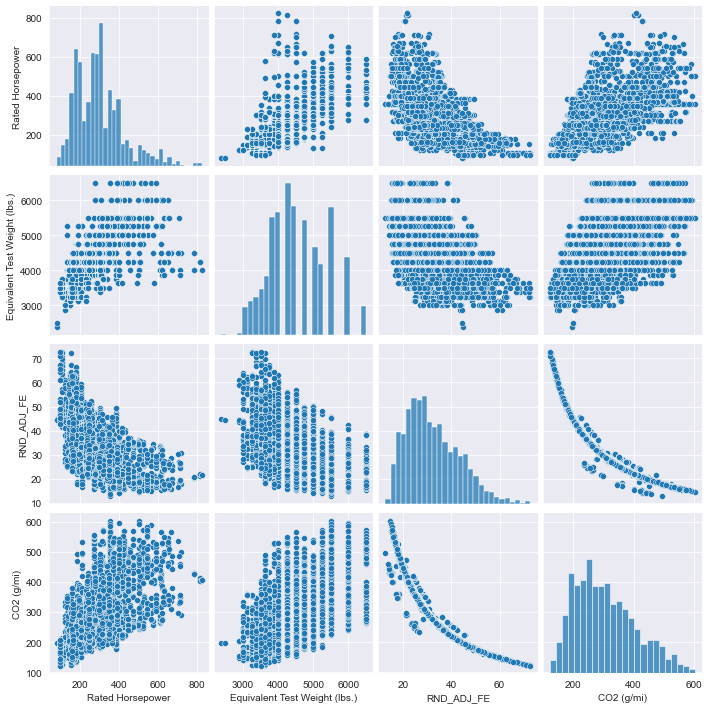

In [72]:
# Pair plot after dropping outliers.

sns.pairplot(df_final);

## Preparation for training

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_final[['Rated Horsepower', 'Equivalent Test Weight (lbs.)', 'CO2 (g/mi)']]
y = df_final['RND_ADJ_FE']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## SGDRegressor

In [74]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Create the hyperparameter grid
param_grid = {
              'tol':[0.0001, 0.001, 0.01, 0.1],
             'max_iter':[50, 100, 500, 1000],
             'n_iter_no_change': [10,50,100]}

# Create the SGDRegressor
sgd_reg = SGDRegressor(alpha = 0.01,
                       early_stopping=True,
                       warm_start=True,
                       l1_ratio=0.15,
                       eta0 = 0.001)

# Create the GridSearchCV object
sgd_cv = GridSearchCV(sgd_reg, param_grid, cv=5)

# Fit it to the data
sgd_cv.fit(X_train, y_train)
y_pred = sgd_cv.predict(X_test)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(sgd_cv.best_params_))
print("Best score is {}".format(sgd_cv.best_score_))
print("R2 score on test set is {}".format(r2_score(y_pred, y_test)))
# print("F1 score on test set is {}".format(f1_score(y_pred, y_test)))
# print("Accuracy score on test set is {}".format(accuracy_score(y_pred, y_test)))

Tuned Parameters: {'max_iter': 500, 'n_iter_no_change': 100, 'tol': 0.01}
Best score is 0.8577763943120361
R2 score on test set is 0.8498826177180576


## KNeighborsRegressor

In [75]:
from sklearn.neighbors import KNeighborsRegressor

# Create the hyperparameter grid
param_grid = {
              'p':[1, 2],
             'leaf_size':[10, 30, 100],
             'n_neighbors': [5, 10],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

# Create the SGDRegressor
knn_reg = KNeighborsRegressor(n_jobs=-1)


# Create the GridSearchCV object
knn_reg_cv = GridSearchCV(knn_reg, param_grid, cv=5)

# Fit it to the data
knn_reg_cv.fit(X_train, y_train)
y_pred = knn_reg_cv.predict(X_test)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(knn_reg_cv.best_params_))
print("Best score is {}".format(knn_reg_cv.best_score_))
print("R2 score on test set is {}".format(r2_score(y_pred, y_test)))
# print("F1 score on test set is {}".format(f1_score(y_pred, y_test)))
# print("Accuracy score on test set is {}".format(accuracy_score(y_pred, y_test)))

Tuned Parameters: {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 5, 'p': 2}
Best score is 0.982431169105593
R2 score on test set is 0.9836991827531714


## Transfer to category

In [76]:
y = np.where(df_final["RND_ADJ_FE"]<30, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## SGDClassifier

In [77]:
from sklearn.linear_model import SGDClassifier

# Create the hyperparameter grid
param_grid = {
              'tol':[0.0001, 0.001, 0.01, 0.1],
             'max_iter':[50, 100, 500, 1000],
             'n_iter_no_change': [10,50,100]}

# Create the SGDRegressor
sgd_clf = SGDClassifier(alpha = 0.01,
                       early_stopping=True,
                       warm_start=True,
                       l1_ratio=0.15,
                       eta0 = 0.001)

# Create the GridSearchCV object
sgd_clf_cv = GridSearchCV(sgd_clf, param_grid, cv=5)

# Fit it to the data
sgd_clf_cv.fit(X_train, y_train)
y_pred = sgd_clf_cv.predict(X_test)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(sgd_clf_cv.best_params_))
print("Best score is {}".format(sgd_clf_cv.best_score_))
print("R2 score on test set is {}".format(r2_score(y_pred, y_test)))
print("F1 score on test set is {}".format(f1_score(y_pred, y_test)))
print("Accuracy score on test set is {}".format(accuracy_score(y_pred, y_test)))

Tuned Parameters: {'max_iter': 100, 'n_iter_no_change': 10, 'tol': 0.001}
Best score is 0.9813852813852814
R2 score on test set is 0.8683213429256594
F1 score on test set is 0.9681742043551089
Accuracy score on test set is 0.967128027681661


## KNeighborsClassifier

In [78]:
from sklearn.neighbors import KNeighborsClassifier

# Create the hyperparameter grid
param_grid = {
              'p':[1, 2],
             'leaf_size':[10, 30, 100],
             'n_neighbors': [5, 10],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

# Create the SGDRegressor
knn_clf = KNeighborsClassifier(n_jobs=-1)


# Create the GridSearchCV object
knn_clf_cv = GridSearchCV(knn_clf, param_grid, cv=5)

# Fit it to the data
knn_clf_cv.fit(X_train, y_train)
y_pred = knn_clf_cv.predict(X_test)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(knn_reg_cv.best_params_))
print("Best score is {}".format(knn_reg_cv.best_score_))
print("R2 score on test set is {}".format(r2_score(y_pred, y_test)))
print("F1 score on test set is {}".format(f1_score(y_pred, y_test)))
print("Accuracy score on test set is {}".format(accuracy_score(y_pred, y_test)))

Tuned Parameters: {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 5, 'p': 2}
Best score is 0.982431169105593
R2 score on test set is 0.8337109360952278
F1 score on test set is 0.959731543624161
Accuracy score on test set is 0.9584775086505191


## Eliminate CO2

In [79]:
X = df_final[['Rated Horsepower', 'Equivalent Test Weight (lbs.)']]
y = df_final['RND_ADJ_FE']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## SGDRegressor without CO2

In [80]:
# Create the hyperparameter grid
param_grid = {
              'tol':[0.0001, 0.001, 0.01, 0.1],
             'max_iter':[50, 100, 500, 1000],
             'n_iter_no_change': [10,50,100]}

# Create the SGDRegressor
sgd_reg_noco2 = SGDRegressor(alpha = 0.01,
                       early_stopping=True,
                       warm_start=True,
                       l1_ratio=0.15,
                       eta0 = 0.001)

# Create the GridSearchCV object
sgd_cv_noco2 = GridSearchCV(sgd_reg_noco2, param_grid, cv=5)

# Fit it to the data
sgd_cv_noco2.fit(X_train, y_train)
y_pred = sgd_cv_noco2.predict(X_test)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(sgd_cv_noco2.best_params_))
print("Best score is {}".format(sgd_cv_noco2.best_score_))
print("R2 score on test set is {}".format(r2_score(y_pred, y_test)))
# print("F1 score on test set is {}".format(f1_score(y_pred, y_test)))
# print("Accuracy score on test set is {}".format(accuracy_score(y_pred, y_test)))

Tuned Parameters: {'max_iter': 1000, 'n_iter_no_change': 50, 'tol': 0.0001}
Best score is 0.3831314012824533
R2 score on test set is -0.38721057723124463


## KNeighborsRegressor without CO2

In [81]:
# Create the hyperparameter grid
param_grid = {
              'p':[1, 2],
             'leaf_size':[10, 30, 100],
             'n_neighbors': [5, 10],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

# Create the SGDRegressor
knn_reg = KNeighborsRegressor(n_jobs=-1)


# Create the GridSearchCV object
knn_reg_cv = GridSearchCV(knn_reg, param_grid, cv=5)

# Fit it to the data
knn_reg_cv.fit(X_train, y_train)
y_pred = knn_reg_cv.predict(X_test)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(knn_reg_cv.best_params_))
print("Best score is {}".format(knn_reg_cv.best_score_))
print("R2 score on test set is {}".format(r2_score(y_pred, y_test)))
# print("F1 score on test set is {}".format(f1_score(y_pred, y_test)))
# print("Accuracy score on test set is {}".format(accuracy_score(y_pred, y_test)))

Tuned Parameters: {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 10, 'p': 1}
Best score is 0.45175414141353587
R2 score on test set is 0.14140192548336517


## Transfer to category

In [82]:
y = np.where(df_final["RND_ADJ_FE"]<30, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## SGDClassifier without CO2

In [83]:
# Create the hyperparameter grid
param_grid = {
              'tol':[0.0001, 0.001, 0.01, 0.1],
             'max_iter':[50, 100, 500, 1000],
             'n_iter_no_change': [10,50,100]}

# Create the SGDRegressor
sgd_clf = SGDClassifier(alpha = 0.01,
                       early_stopping=True,
                       warm_start=True,
                       l1_ratio=0.15,
                       eta0 = 0.001)

# Create the GridSearchCV object
sgd_clf_cv = GridSearchCV(sgd_clf, param_grid, cv=5)

# Fit it to the data
sgd_clf_cv.fit(X_train, y_train)
y_pred = sgd_clf_cv.predict(X_test)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(sgd_clf_cv.best_params_))
print("Best score is {}".format(sgd_clf_cv.best_score_))
print("R2 score on test set is {}".format(r2_score(y_pred, y_test)))
print("F1 score on test set is {}".format(f1_score(y_pred, y_test)))
print("Accuracy score on test set is {}".format(accuracy_score(y_pred, y_test)))

Tuned Parameters: {'max_iter': 50, 'n_iter_no_change': 10, 'tol': 0.001}
Best score is 0.7203463203463203
R2 score on test set is -0.04951899951899974
F1 score on test set is 0.7336860670194004
Accuracy score on test set is 0.7387543252595156


## KNeighborsClassifier without CO2

In [84]:
# Create the hyperparameter grid
param_grid = {
              'p':[1, 2],
             'leaf_size':[10, 30, 100],
             'n_neighbors': [5, 10],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

# Create the SGDRegressor
knn_clf = KNeighborsClassifier(n_jobs=-1)


# Create the GridSearchCV object
knn_clf_cv = GridSearchCV(knn_clf, param_grid, cv=5)

# Fit it to the data
knn_clf_cv.fit(X_train, y_train)
y_pred = knn_clf_cv.predict(X_test)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(knn_reg_cv.best_params_))
print("Best score is {}".format(knn_reg_cv.best_score_))
print("R2 score on test set is {}".format(r2_score(y_pred, y_test)))
print("F1 score on test set is {}".format(f1_score(y_pred, y_test)))
print("Accuracy score on test set is {}".format(accuracy_score(y_pred, y_test)))

Tuned Parameters: {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 10, 'p': 1}
Best score is 0.45175414141353587
R2 score on test set is -0.20944222847054217
F1 score on test set is 0.6812749003984064
Accuracy score on test set is 0.7231833910034602


## 1)Provide a detailed description of the outlier analysis.

The pair plots in the beginning shows that there are some huge outliers in the response `RND_ADJ_FE` but not many in the other features. After dropping the outliers that are identified by at least two methods, minor change appears on the features but the scatter plots in the pair plot of `RND_ADJ_FE` becomes a curve.



In [85]:
print(df_dna["y_pred_lof_2"].value_counts())
print(df_dna["y_pred_if_2"].value_counts())
print(df_dna["y_pred_rob_2"].value_counts())
print(df_dna["all_out"].value_counts())

 0    2854
-1     151
Name: y_pred_lof_2, dtype: int64
 0    2854
-1     151
Name: y_pred_if_2, dtype: int64
 0    2854
-1     151
Name: y_pred_rob_2, dtype: int64
 0    2689
-1     199
-2      97
-3      20
Name: all_out, dtype: int64


## 2)Provide a detailed summary of your findings comparing regression and classification models.

The R2 score of SGD increases from 0.82 in regression model to 0.9 in classification model. This is because in regression models the error will always be positive unless the predicted value and true value is exactly the same. But in classification models even if the predicted value is not the same as the true value, they can still fall in the same category.

The mean cross validate score of knn regressor and knn classifier are almost the same but the R2 score decreased from 0.9 to 0.83. One possible reason could be the error for each point in regressor is diminished by taking the mean of n neighbours. But the error of classifier is always 0 or 1. The F1 score and accuracy for knn regressor is however pretty high, 0.98, which could support this assertion.

After eliminating the feature CO2, the R2 scores decrease dramatically for every model. This can be explained by the high variance in the remaining two features showed in the pair plot. The F1 and accuracy scores are however not too low.

## 3)What recommendations would you make to enhance the findings from this analysis?

Should try using CO2 as the only training feature if we focus on the R2 score.

We should use sgd in classification situation and knn in regression setting.

# 4)What anomalies or issues did you notice with the data?

The variance in `Rated Horsepower` and `Equivalent Test Weight (lbs.)` is too high. Although there seem to be a curve in their scatter plots against the response, the points expand far away from that curve so that models perform badly on those two features.